### Tutorial to extract coordinates from ROIs saved ImageJ/Fiji and map to an atlas.
Assumes:
1. Registration (step 1, 2, 3) is complete.
2. Points or ROIs were drawn in the sagittal registered volumes (`result.1.tif` or `result.tif`)
3. Multiple ROIs were saved as a `.zip` file in ImageJ/Fiji

In this experiment, a fiber was placed in the brain for fiber photometry, and 5 points were clicked in each fiber site.

In [1]:
#imports
import os, numpy as np, time, cv2
from skimage.external import tifffile
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
from skimage.morphology import ball
#change working directory
os.chdir("/jukebox/wang/zahra/python/lightsheet_py3")
from tools.conv_net.utils.io import read_roi_zip
from tools.registration.transform import transformed_pnts_to_allen_helper_func
from tools.registration.register import count_structure_lister
from tools.utils.io import load_kwargs

Set a prefix name (e.g. mouse name) for the files and paths to sample atlas image and ROIs.

In [2]:
#brainname, added as a prefix for all files
brain = "mouse10"

#roi pth
roi_pth = os.path.join(os.getcwd(), "supp_files/fiber_points_RoiSet.zip")
print(roi_pth)
#downsized atlas
atl_pth = os.path.join(os.getcwd(), "supp_files/pma_downsampled.tif")

#sample brain
vol = os.path.join(os.getcwd(), "supp_files/fiber_downsampled.tif") 

#destination folder (something like)
fld = "/home/wanglab/Desktop"

/home/wanglab/mounts/wang/zahra/python/lightsheet_py3/supp_files/fiber_points_RoiSet.zip


Let's import the ROIs from the `.zip` file make in ImageJ/Fiji, translate them into the coronal and horizontal orientation, and output Princeton Mouse atlas coordinates (in this case).

The output will be in the destination folder set above, in a folder named `points_merged_to_atlas`.

In [3]:
assert os.path.exists(roi_pth), "nonexistent ROIs"

#get rois
zyx_rois_sag = np.asarray([[int(yy) for yy in xx.replace(".roi", "").split("-")] for xx in read_roi_zip(roi_pth, include_roi_name=True)])
#slice into diff orientations
zyx_rois_cor = np.asarray([[xx[1], xx[2], xx[0]] for xx in zyx_rois_sag])
zyx_rois_hor = np.asarray([[xx[2], xx[1], xx[0]] for xx in zyx_rois_sag])

#make destination path
dst = os.path.join(fld, "points_merged_to_atlas")
if not os.path.exists(dst): os.mkdir(dst)

#export coordinates
if os.path.exists(os.path.join(dst, "{}_allen_coordinates.txt".format(brain))): os.remove(os.path.join(dst, "{}_allen_coordinates.txt".format(brain)))
with open(os.path.join(dst, "{}_allen_coordinates.txt".format(brain)), "a") as txt:
    txt.write("Allen Atlas CCF coordinates (zyx) in the horizontal orientation:\n%s\n" % zyx_rois_hor)
    txt.write("\nAllen Atlas CCF coordinates (zyx) in the saggital orientation:\n%s\n" % zyx_rois_sag)
    txt.write("\nAllen Atlas CCF coordinates (zyx) in the coronal orientation:\n%s" % zyx_rois_cor)

Now let's take the ROIs, find their mean x, y, z dimension coordinate for each site, and map it onto the atlas as a merged RBG image that you can open in ImageJ/Fiji.

In [4]:
#MERGED IMAGES TO ATLAS
#atlas (sagittal)
atl = tifffile.imread(atl_pth)
atl_cnn = np.zeros_like(atl)

#make a merged map for the volume as well   
sag_site1 = zyx_rois_sag[0:5]; sag_site2 = zyx_rois_sag[5:];
sag_site1_av = sag_site1.mean(axis = 0).astype(int); sag_site2_av = sag_site2.mean(axis = 0).astype(int)
atl_cnn[sag_site1_av[0]-1:sag_site1_av[0]+1, sag_site1_av[1], sag_site1_av[2]] = 1
atl_cnn[sag_site2_av[0]-1:sag_site2_av[0]+1, sag_site2_av[1], sag_site2_av[2]] = 1

#apply dilation
r = 2
selem = ball(r)[int(r/2)]
atl_cnn = atl_cnn.astype("uint8")
atl_cnn = np.asarray([cv2.dilate(atl_cnn[i], selem, iterations = 1) for i in range(atl_cnn.shape[0])])
 
merged_atlas = np.stack([atl, atl_cnn, np.zeros_like(atl)], -1)
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_atlas_sagittal.tif".format(brain)), merged_atlas)

Let's see how this look looks in each channel.

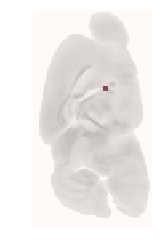

In [5]:
plt.axis("off")
plt.imshow(merged_atlas[39, :, :, 0], cmap = "gist_yarg", alpha = 0.5)
plt.imshow(merged_atlas[39, :, :, 1], cmap = "Reds", alpha = 0.5)

Similarly we can make overlays of the the registered lightsheet image and the points that were selected in the ROIs.

In [6]:
#MERGED IMAGES TO REGISTERED VOLUMES
#get registered volumes for overlay - this will be a saggital image
img = tifffile.imread(vol)
img_cnn = np.zeros_like(img)

#make a merged map for the volume as well   
img_cnn[sag_site1_av[0]-1:sag_site1_av[0]+1, sag_site1_av[1], sag_site1_av[2]] = 1
img_cnn[sag_site2_av[0]-1:sag_site2_av[0]+1, sag_site2_av[1], sag_site2_av[2]] = 1

#apply dilation
r = 3
selem = ball(r)[int(r/2)]
img_cnn = img_cnn.astype("uint8")
img_cnn = np.asarray([cv2.dilate(img_cnn[i], selem, iterations = 1) for i in range(img_cnn.shape[0])])

#make the merged saggital stack
merged_img_sag = np.stack([img, img_cnn, np.zeros_like(img)], -1)
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_registered_image_sagittal.tif".format(brain)), merged_img_sag)

#### With a real dataset
An easy way to load the registered volume of a brain processed through the lightsheet pipeline is to load the parameter dictionary signifying the paths to various volumes. To do this, you can simply load the parameters and then load the registered volume of the channel that best represents your data. Below is an example code on how to do this instead of loading the sample registered volume `vol`.

In [ ]:
from tools.utils.io import load_kwargs

kwargs = load_kwargs()#insert sample path containing param_dict.p file
#to overlay on designated "injection" channel image
img = [vol.ch_to_reg_to_atlas for vol in kwargs["volumes"] if vol.ch_type == "injch"]
#if not just get the regular reg channel
if len(img) == 0: img = [vol.reg_to_atlas_vol for vol in kwargs["volumes"] if vol.ch_type == "regch"]
#just need the one in the list
img = tifffile.imread(img[0])

A good way to check (and perhaps quantify later) how well registration worked is to overlay the atlas image on the registered volume. Simultaenously you could also look at an overlay of the dilated points on the same RGB volume. Here, the red is the registered volume, the green is the atlas, and the blue are the points signifying the fiber tip. In this data a coronal reslice gives us the best visual of the points.

In [7]:
#MERGED CORONAL IMAGES TO REGISTERED VOLUMES AND ATLAS FOR MAXIP
#reslice
#both these images have the same dims
coronal_atlas = np.transpose(atl, [1, 2, 0]) #make coronal sections
coronal_img = np.transpose(img, [1, 2, 0])

print("\ncheck to make sure they both have the same shape:\n")
print(coronal_atlas.shape, coronal_img.shape)

#init
cor_cnn = np.zeros_like(coronal_img)

#make new circles marking fiber site... use this to overlay both on atlas and image
cor_site1 = zyx_rois_cor[0:5]; cor_site2 = zyx_rois_cor[5:];
cor_site1_av = cor_site1.mean(axis = 0).astype(int); cor_site2_av = cor_site2.mean(axis = 0).astype(int)
cor_cnn[cor_site1_av[0]-2:cor_site1_av[0]+2, cor_site1_av[1], cor_site1_av[2]] = 1
cor_cnn[cor_site2_av[0]-2:cor_site2_av[0]+2, cor_site2_av[1], cor_site2_av[2]] = 1

#apply dilation
r = 2
selem = ball(r)[int(r/2)]
cor_cnn = cor_cnn.astype("uint8")
cor_cnn = np.asarray([cv2.dilate(cor_cnn[i], selem, iterations = 1) for i in range(cor_cnn.shape[0])])

#merge
merged_atlas_coronal = np.stack([coronal_atlas, cor_cnn, np.zeros_like(coronal_atlas)], -1)
merged_img_coronal = np.stack([coronal_img, cor_cnn, np.zeros_like(coronal_img)], -1)
#merge both registered volume and atlas to see registration quality
merged_img_atlas_coronal = np.stack([coronal_img, coronal_atlas, cor_cnn], -1)

#save out coronal sections - based on the fact that you click 5 points in each site in sagittal sections
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_atlas_and_registered_volume_coronal.tif".format(brain)), merged_img_atlas_coronal.astype("uint16"))
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_atlas_coronal.tif".format(brain)), merged_atlas_coronal.astype("uint16"))


check to make sure they both have the same shape:

((137, 75, 75), (137, 75, 75))


Sometimes if you have sparse objects (in this case, two fibers) it can be hard to see exactly where they are while scrolling through the whole brain. So you can also make smaller sections of a few z planes where each of the objects are, now that you have the ROIs.

In [8]:
#next, make smaller sections to visualise site better
z = np.nonzero(cor_cnn)[0]

#find z range of sites
site1 = z[0:(z.shape[0]/2)]; site2 = z[(z.shape[0]/2)+1:]
zrange_site1 = range(min(site1)-1, max(site1)+2); zrange_site2 = range(min(site2)-1, max(site2)+2)

Since you only have a few z planes now, a max projection will be appropriate and easy to visualize. Remember that the image resolution will determine how many microns you are ultimately taking the max projection by. The stacks are also separately saved as a `.tif` for further use.

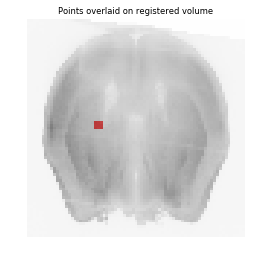

In [9]:
#doing a max projection
maxip1 = np.max(merged_atlas_coronal[zrange_site1], 0)
maxip2 = np.max(merged_atlas_coronal[zrange_site2], 0)

#TO REGISTERED IMAGE
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_registered_image_coronal.tif".format(brain)), merged_img_coronal)
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_registered_image_coronal_site1_z{}_{}.tif".format(brain, min(zrange_site1),
                                                                max(zrange_site1))), merged_img_coronal[zrange_site1])
tifffile.imsave(os.path.join(dst, "{}_points_merged_to_registered_image_coronal_site2_z{}_{}.tif".format(brain, min(zrange_site2), 
                                                                max(zrange_site2))), merged_img_coronal[zrange_site2])

#doing a max projection
maxip1 = np.max(merged_img_coronal[zrange_site1], 0)
maxip2 = np.max(merged_img_coronal[zrange_site2], 0)

alpha = 0.5 #determines transparency
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "red"]) #color makes cells pop
plt.axis("off")
plt.imshow(maxip1[...,0], "gist_yarg")
plt.imshow(maxip1[...,1], cmap, alpha = alpha)
plt.title("Points overlaid on registered volume", fontsize = "small")
plt.savefig(os.path.join(dst, "{}_points_merged_to_registered_image_coronal_site1_maxip_z{}_{}.pdf".format(brain, min(zrange_site1), max(zrange_site1))), dpi = 300)

plt.imshow(maxip2[...,0], "gist_yarg")
plt.imshow(maxip2[...,1], cmap, alpha = alpha)
plt.title("Points overlaid on registered volume", fontsize = "small")
plt.savefig(os.path.join(dst, "{}_points_merged_to_registered_image_coronal_site2_maxip_z{}_{}.pdf".format(brain, min(zrange_site2), max(zrange_site2))), dpi = 300)

You can further map these points (clicked in atlas space) to the corresponding lookup table containing the structures corresponding the coordinates your site is located in. This invovles a basic one-to-one mapping and outputs a lookup table with an addition `cell_count` column that has the number of points belonging to each structure, in this case.

**NOTE**: this mapping will not be accurate for this demo dataset as images have been downsampled and datatypes altered, but the idea is the same for original atlas, registered, and annotation volumes.

In [10]:
#make allen structure LUT
zyx_rois = zyx_rois_sag

#convert to structure
#path to annotation file
ann_pth = os.path.join(os.getcwd(), "supp_files/ann_downsampled.tif")
ann = tifffile.imread(ann_pth)
points = transformed_pnts_to_allen_helper_func(list(zyx_rois), ann, order = "ZYX")    

#make dataframe
lut_path = os.path.join(os.getcwd(), "supp_files/ls_id_table_w_voxelcounts.xlsx")
df = count_structure_lister(lut_path, *points)
df.to_excel(os.path.join(dst, "{}_PMA_structures.xlsx".format(brain)))


*************0 points do not map to atlas*********
